#### Estimating the Health Burden of Wind Energy Accidents Using DALYs

We estimate the health burden of wind energy accidents in Europe by calculating DALYs (Disability-Adjusted Life Years) using disability weight (DW) from the Global Burden of Disease Study 2021 and using a fictitious dataset of fatalities and injuries as exercise.

![Final DALYs Plot](final_plot.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

The disability weight (DW) data comes from the Global Burden of Disease Study 2021 (GBD 2021), which quantifies the health impact of various conditions. It includes disability weights (Mean, Lower, Upper) for different injuries and illnesses, ranging from 0 (perfect health) to 1 (death).

Source: *https://ghdx.healthdata.org/record/ihme-data/gbd-2021-disability-weights*

**1.** We load and preprocess disability weight (DW) data from an Excel file, filtering for injury-related sequelae while excluding non-accident-related conditions. The filtered data is cleaned, sorted, and summarized, calculating the mean DW values for further DALY computations.

In [2]:
# Load Disability Weights data from the "DB" sheet from excel file
file_path = "DataBase_DW_05macth2025.xlsx"  
df_dw = pd.read_excel(file_path, sheet_name="DB")

# Rename columns for clarity
df_dw = df_dw.rename(columns={"Mean": "DW_mean","Lower": "DW_lower","Upper": "DW_upper"})

# Define keywords to filter injury-related sequelae
injury_keywords = [
    # General injuries
    "fracture", "burn", "wound", "trauma", "injury", "concussion", "pain", "contusion", "laceration", "amputation",
    # Transport-related injuries
    "vehicle", "motorcycle", "car", "truck", "collision", "crash", "traffic", "road", "pedestrian", "bicycle", "transport", "accident",
    # Energy sector-related injuries
    "electrocution", "shock", "thermal", "radiation", "chemical", "explosion", "fire", "hazard", "high-voltage", "machinery", "fall", "crush", "industrial",
    # Wind energy-specific injuries
    "turbine", "blade", "tower", "mechanical", "gearbox", "impact", "wind", "height", "rope", "maintenance", "installation"
]

# Define exclusion keywords for non-accident-related conditions
exclusion_keywords = [
    # Infectious diseases
    "infection", "tuberculosis", "hiv", "aids", "malaria", "diabetes", "caries", "ascariasis", "syphilis", "worm",
    # Congenital and chronic conditions
    "congenital atresia", "endometriosis", "birth asphyxia", "urticaria", "endocarditis", "myocarditis", "myocardial infarction",
    "cell carcinoma", "genital prolapse", "uterine prolapse", "congenital", "cardiomyopathy", "asymptomatic", "premenstrual syndrome", "cardiovascular"   
]

# Filter for injury-related sequelae and exclude non-accident conditions
df_dw_filtered = df_dw[df_dw['Sequela Name'].str.contains('|'.join(injury_keywords), case=False, na=False)]
df_dw_filtered = df_dw_filtered[~df_dw_filtered['Sequela Name'].str.contains('|'.join(exclusion_keywords), case=False, na=False)]
# Remove rows with missing or empty DW_mean values
df_dw_filtered = df_dw_filtered.dropna(subset=["DW_mean"])
df_dw_filtered = df_dw_filtered[df_dw_filtered["DW_mean"].notnull() & (df_dw_filtered["DW_mean"] != "")]
# Sort filtered data by DW_mean in descending order
df_dw_filtered = df_dw_filtered.sort_values(by="DW_mean", ascending=False)

# Truncate long text fields for better readability in tabulated output
df_dw_filtered_display = df_dw_filtered.copy()
# Remove 'Reference' column before displaying
if "Reference" in df_dw_filtered_display.columns:
    df_dw_filtered_display = df_dw_filtered_display.drop(columns=["Reference"])
df_dw_filtered_display["Sequela Name"] = df_dw_filtered_display["Sequela Name"].str[:40] + '...'
df_dw_filtered_display["Health State Name"] = df_dw_filtered_display["Health State Name"].str[:40] + '...'
df_dw_filtered_display["Health State Lay Description"] = df_dw_filtered_display["Health State Lay Description"].str[:40] + '...'

# Calculate the mean values for DW_mean, DW_lower, and DW_upper
dw_mean_values = df_dw_filtered[["DW_mean", "DW_lower", "DW_upper"]].mean()
DW_mean_value = dw_mean_values.iloc[0]

print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Selected injury-related sequelae:")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
# Display tabulated data with truncated text without the index
print(tabulate(df_dw_filtered_display, headers='keys', tablefmt='plain', floatfmt=".4", showindex=False))
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
# Display mean values for DW 
print("Mean DW values:")
print(dw_mean_values)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Selected injury-related sequelae:
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sequela Name                                 Health State Name                            Health State Lay Description                   DW_mean    DW_lower    DW_upper
Most severe low back pain with leg pain...   Back pain, most severe, with leg pain...     has constant back and leg pain, which ca...    0.3841      0.2561      0.5177
Most severe low back pain without leg pa...  Back pain, most severe, without leg pain...  has constant back pain, which causes dif...    0.3722      0.2503      0.5056
Severe low back pain with leg pain...  

**Result:** We are considering **musculoskeletal disorders** related to back and neck pain, including severe to mild low back pain (with and without leg pain) and severe to mild neck pain. This selection is in line with the following study.  

*Cooper, K., Kirkpatrick, P., & Stewart, A. (2014). Health effects associated with working in the wind power generation industry: a comprehensive systematic review. JBI Evidence Synthesis, 12(11), 327-373.*  

The mean disability weight (DW) for this subset is shown below.

In [3]:
DW_mean_value

0.18342705529166667

**2.** We use a fictitious dataset on wind energy accidents in Europe, including fatalities, injuries, and key variables like workforce age, life expectancy, and injury duration.

In [4]:
# Data simulated 
accidents_file_path = "Country_Wind_Energy_Accidents.xlsx"  # Ensure the file is in the working directory
df_accidents = pd.read_excel(accidents_file_path, sheet_name="DB")

#  fictitious Parameters:
injury_duration = 5  # assumed duration of disability (L) in years
life_expectancy = {
    "Germany": 81, "France": 82, "Spain": 83, "Italy": 83, "Austria": 81
}
# Define default life expectancy for missing countries
default_life_expectancy = 82  

**3.** We compute DALYs (Disability-Adjusted Life Years) by estimating Years Lived with Disability (YLD) from injuries and Years of Life Lost (YLL) from fatalities, based on country-specific life expectancy. 

In [5]:
# Compute Years Lived with Disability (YLD)
df_accidents["YLD"] = df_accidents["Injuries"] * dw_mean_values["DW_mean"] * injury_duration
# Assign life expectancy based on country
df_accidents["Life_Expectancy"] = df_accidents["Country"].map(life_expectancy).fillna(default_life_expectancy)
# Compute remaining life expectancy (L = Life Expectancy - Avg Workforce Age)
df_accidents["Life_Expectancy_Remaining"] = df_accidents["Life_Expectancy"] - df_accidents["Avg_Workforce_Age"]
# Compute Years of Life Lost (YLL)
df_accidents["YLL"] = df_accidents["Fatalities"] * df_accidents["Life_Expectancy_Remaining"]
# Compute Total DALYs (Disability-Adjusted Life Years)
df_accidents["DALY"] = df_accidents["YLL"] + df_accidents["YLD"]
# Reorder columns for clarity
column_order = ["Country", "Year", "Fatalities", "Injuries", "Avg_Workforce_Age","Life_Expectancy", "Life_Expectancy_Remaining","YLD","YLL","DALY"]
df_accidents = df_accidents[column_order]
# Display tabulated accident data
print("Accident Data with DALY Calculations:")
print(tabulate(df_accidents, headers='keys', tablefmt='plain', floatfmt=".4", showindex=False))

Accident Data with DALY Calculations:
Country        Year    Fatalities    Injuries    Avg_Workforce_Age    Life_Expectancy    Life_Expectancy_Remaining     YLD    YLL     DALY
France         2017             3          10                 40.7               82.0                         41.3   9.171  123.9  133.1
France         2018             2          11                 43.3               82.0                         38.7  10.09    77.4   87.49
France         2019             1           6                 41.5               82.0                         40.5   5.503   40.5   46.0
France         2020             2          13                 41.7               82.0                         40.3  11.92    80.6   92.52
France         2021             2           4                 40.2               82.0                         41.8   3.669   83.6   87.27
France         2022             3           6                 40.0               82.0                         42.0   5.503  126.0  131.

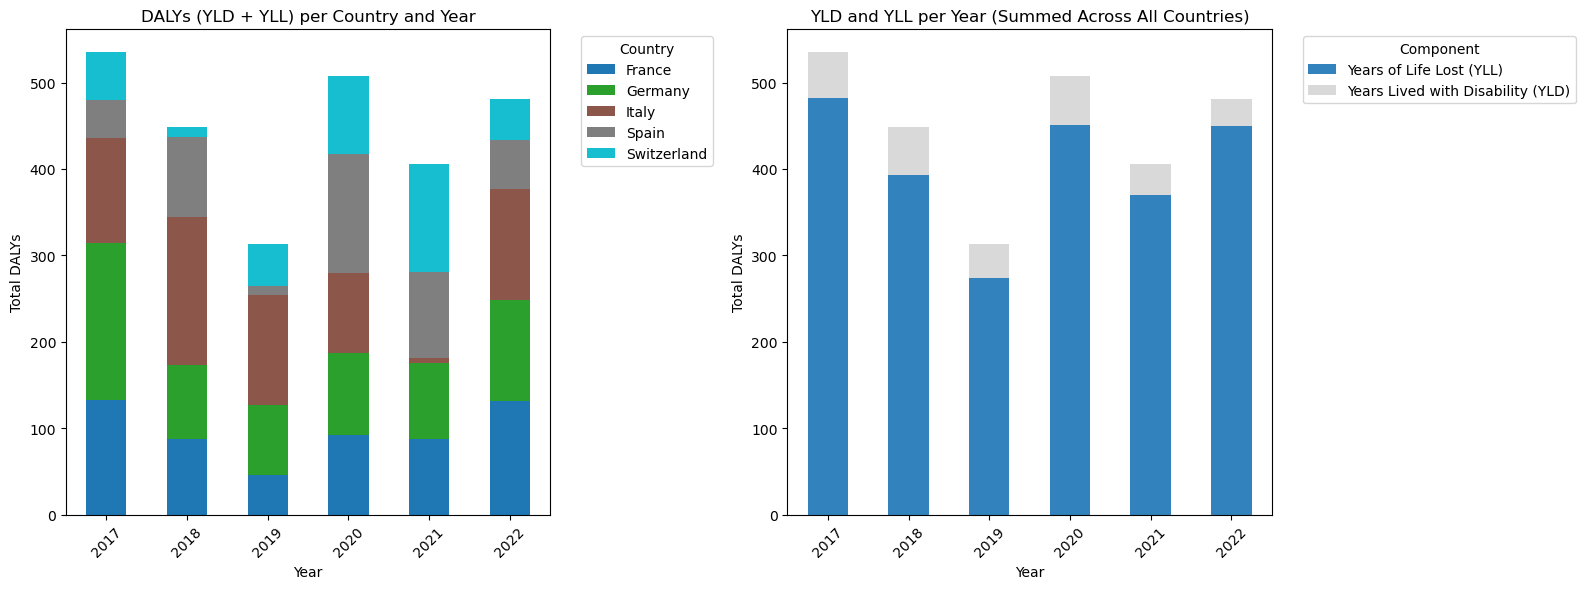

In [6]:
import matplotlib.pyplot as plt
# Aggregate DALYs per year and country
df_dalys = df_accidents.groupby(["Year", "Country"])["DALY"].sum().unstack()

# Aggregate YLD and YLL per year (summing across all countries)
df_yld_yll = df_accidents.groupby("Year")[["YLL", "YLD"]].sum()

# Create a figure with two subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot 1: DALYs per Country and Year
df_dalys.plot(kind="bar", stacked=True, ax=axes[0], colormap="tab10")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Total DALYs")
axes[0].set_title("DALYs (YLD + YLL) per Country and Year")
axes[0].legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: YLD and YLL per Year (Summed Across All Countries)

# Rename columns for better legend labels
df_yld_yll = df_yld_yll.rename(columns={"YLD": "Years Lived with Disability (YLD)", "YLL": "Years of Life Lost (YLL)"})
df_yld_yll.plot(kind="bar", stacked=True, ax=axes[1], colormap="tab20c")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total DALYs")
axes[1].set_title("YLD and YLL per Year (Summed Across All Countries)")
axes[1].legend(title="Component", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better visualization
plt.tight_layout()
# Show both plots together in one row

fig.savefig("final_plot.png", dpi=300, bbox_inches="tight")
plt.show()


